In [4]:
import tensorflow as tf
import optuna
import shap
from tensorflow.keras.models import Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, backend, constraints, initializers, regularizers
from sklearn.preprocessing import StandardScaler

In [ ]:
! pip install optuna

In [ ]:
!pip install shap

In [8]:
df = pd.read_csv('truncated_LOB_data_BTC_USD_COINBASE.csv')

In [48]:
df

,timestamp,bid_prices_0,ask_prices_0,bid_quantity_0,ask_quantity_0,bid_prices_1,ask_prices_1,bid_quantity_1,ask_quantity_1,bid_prices_2,...,ask_quantity_4,time_bid_prices_0,time_ask_prices_0,time_bid_prices_1,time_ask_prices_1,time_bid_prices_2,time_bid_prices_3,time_ask_prices_3,time_bid_prices_4,time_ask_prices_4
0,2023-10-02 00:00:00.047811072,27995.45,27995.46,2.969115,0.171891,27994.28,27996.67,0.115522,0.020000,27994.26,...,0.161504,4.29,4.29,0.38,0.59,0.44,0.44,0.44,0.44,0.44
1,2023-10-02 00:00:00.199801088,27995.45,27995.46,2.969115,0.171891,27994.28,27996.67,0.078016,0.020000,27994.26,...,0.161504,4.14,4.14,0.23,0.43,0.29,0.29,0.29,0.29,0.29
2,2023-10-02 00:00:00.242750976,27995.45,27995.46,2.969115,0.421891,27994.28,27996.67,0.078016,0.020000,27994.26,...,0.161504,4.09,4.09,0.18,0.39,0.24,0.24,0.25,0.24,0.25
3,2023-10-02 00:00:00.303438848,27995.45,27995.46,2.969115,0.421891,27994.28,27996.67,0.078016,0.020000,27994.26,...,0.500000,4.03,4.03,0.12,0.33,0.18,0.18,0.12,0.18,0.12
4,2023-10-02 00:00:00.395410176,27995.45,27995.46,2.969115,0.420490,27994.28,27996.67,0.078016,0.020000,27994.26,...,0.500000,3.94,3.94,0.03,0.24,0.09,0.09,0.02,0.09,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103081,2023-10-02 00:10:12.153671936,27968.27,27970.24,0.171501,0.020000,27968.26,27970.25,0.020000,0.053564,27967.98,...,0.028795,0.00,85787.85,0.00,85787.85,0.00,0.00,85787.85,0.00,85787.85
103082,2023-10-02 00:10:12.154450944,27968.28,27970.24,0.158101,0.020000,27968.27,27970.25,0.171501,0.053564,27968.26,...,0.028795,85787.85,85787.85,85787.85,85787.85,85787.85,85787.85,85787.85,0.00,85787.85
103083,2023-10-02 00:10:12.158212864,27968.28,27970.24,0.158101,0.020000,27968.27,27970.25,0.171501,0.053564,27968.26,...,0.028795,85787.84,85787.84,85787.84,85787.84,85787.84,85787.84,85787.84,85787.84,85787.84
103084,2023-10-02 00:10:12.158674944,27968.28,27970.24,0.158101,0.020000,27968.27,27970.25,0.171501,0.053564,27968.26,...,0.214506,85787.84,85787.84,85787.84,85787.84,85787.84,85787.84,85787.84,85787.84,85787.84


In [9]:
def finder_of_fulfilment(df, column):
    time, indicator = [], []
    if 'bid' in column:
      repr_column = 'ask_prices_0'
    else:
      repr_column = 'bid_prices_0'
    for i in range(len(df)):
        num = df[column].iloc[i]
        arr = df[df[repr_column]>num][repr_column].index
        time.append(pd.to_datetime(df['timestamp'].iloc[arr[arr>i][0]]) - pd.to_datetime(df['timestamp'].iloc[i])
                    if len(arr[arr>i]) else
                    pd.to_datetime('2023-10-03 00:00:00') - pd.to_datetime(df['timestamp'].iloc[i]))
    return time

In [10]:
columns = ['bid_prices_0', 'ask_prices_0',	'bid_prices_1',	'ask_prices_1',	'bid_prices_2', 'ask_prices_2', 'bid_prices_3', 'ask_prices_3', 'bid_prices_4',	'ask_prices_4']
for column in columns:
  df['time_'+column] =  finder_of_fulfilment(df, column)

In [19]:
for column in columns:
  df['time_'+column] = round((df['time_'+column]).dt.total_seconds().astype(float),2)

In [20]:
df

,timestamp,bid_prices_0,ask_prices_0,bid_quantity_0,ask_quantity_0,bid_prices_1,ask_prices_1,bid_quantity_1,ask_quantity_1,bid_prices_2,...,ask_quantity_4,time_bid_prices_0,time_ask_prices_0,time_bid_prices_1,time_ask_prices_1,time_bid_prices_2,time_bid_prices_3,time_ask_prices_3,time_bid_prices_4,time_ask_prices_4
0,2023-10-02 00:00:00.047811072,27995.45,27995.46,2.969115,0.171891,27994.28,27996.67,0.115522,0.020000,27994.26,...,0.161504,4.29,4.29,0.38,0.59,0.44,0.44,0.44,0.44,0.44
1,2023-10-02 00:00:00.199801088,27995.45,27995.46,2.969115,0.171891,27994.28,27996.67,0.078016,0.020000,27994.26,...,0.161504,4.14,4.14,0.23,0.43,0.29,0.29,0.29,0.29,0.29
2,2023-10-02 00:00:00.242750976,27995.45,27995.46,2.969115,0.421891,27994.28,27996.67,0.078016,0.020000,27994.26,...,0.161504,4.09,4.09,0.18,0.39,0.24,0.24,0.25,0.24,0.25
3,2023-10-02 00:00:00.303438848,27995.45,27995.46,2.969115,0.421891,27994.28,27996.67,0.078016,0.020000,27994.26,...,0.500000,4.03,4.03,0.12,0.33,0.18,0.18,0.12,0.18,0.12
4,2023-10-02 00:00:00.395410176,27995.45,27995.46,2.969115,0.420490,27994.28,27996.67,0.078016,0.020000,27994.26,...,0.500000,3.94,3.94,0.03,0.24,0.09,0.09,0.02,0.09,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103081,2023-10-02 00:10:12.153671936,27968.27,27970.24,0.171501,0.020000,27968.26,27970.25,0.020000,0.053564,27967.98,...,0.028795,0.00,85787.85,0.00,85787.85,0.00,0.00,85787.85,0.00,85787.85
103082,2023-10-02 00:10:12.154450944,27968.28,27970.24,0.158101,0.020000,27968.27,27970.25,0.171501,0.053564,27968.26,...,0.028795,85787.85,85787.85,85787.85,85787.85,85787.85,85787.85,85787.85,0.00,85787.85
103083,2023-10-02 00:10:12.158212864,27968.28,27970.24,0.158101,0.020000,27968.27,27970.25,0.171501,0.053564,27968.26,...,0.028795,85787.84,85787.84,85787.84,85787.84,85787.84,85787.84,85787.84,85787.84,85787.84
103084,2023-10-02 00:10:12.158674944,27968.28,27970.24,0.158101,0.020000,27968.27,27970.25,0.171501,0.053564,27968.26,...,0.214506,85787.84,85787.84,85787.84,85787.84,85787.84,85787.84,85787.84,85787.84,85787.84


In [41]:
def plot_KM_estimator(column):
  #df['time_'+column] = round((df['time_'+column]).dt.total_seconds().astype(float),2)
  times = np.sort(df['time_'+column].unique())
  S_of_t = []

  for time in times:
      num_executed = len(df[df['time_'+column]==time])
      num_survived = len(df[df['time_'+column]>time])
      prob = num_executed/(num_survived+num_executed)
      S_of_t.append(1-prob)


  S_hat = np.cumprod(S_of_t)
  return S_hat, times

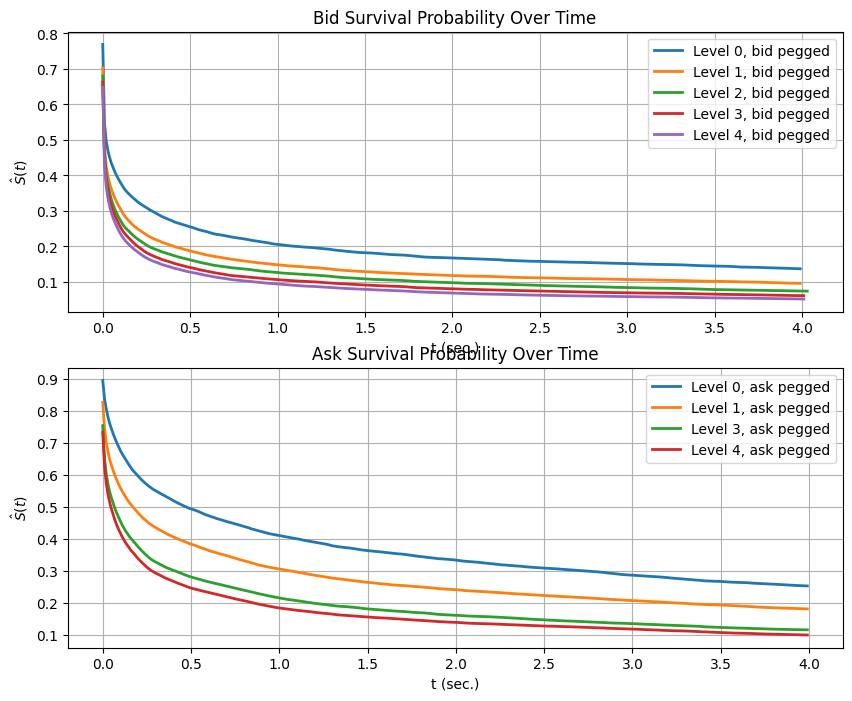

In [47]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

for column in columns:
  KM_est, times = plot_KM_estimator(column)
  if 'bid' in column:
    ax1.plot(times[:400], KM_est[:400], linewidth=2, label=f"Level {column.split('_')[-1]}, {column.split('_')[0]} pegged")
    ax1.set_xlabel('t (sec.)')
    ax1.set_ylabel('$\hat{S}(t)$')
    ax1.set_title('Bid Survival Probability Over Time')
    ax1.legend()
    ax1.grid(True)

  else:
    ax2.plot(times[:400], KM_est[:400], linewidth=2, label=f"Level {column.split('_')[-1]}, {column.split('_')[0]} pegged")
    ax2.set_xlabel('t (sec.)')
    ax2.set_ylabel('$\hat{S}(t)$')
    ax2.set_title('Ask Survival Probability Over Time')
    ax2.legend()
    ax2.grid(True)

plt.show()

In [49]:
#Make some features and drop useless columns
pd.options.mode.chained_assignment = None

df['vol_imbalance'] = (df['bid_quantity_0'] - df['ask_quantity_0'])/(df['bid_quantity_0'] + df['ask_quantity_0'])
df['microprice'] = ((df['bid_prices_0']*df['bid_quantity_0']+df['ask_prices_0']*df['ask_quantity_0'])
                    /(df['bid_quantity_0'] + df['ask_quantity_0']))

def logReturns(S):
    return np.log(S/S.shift(1))

def volFromTimeSeriesPerSecond(prices, timeStamps):
    if np.size(prices) <= 2:
        raise ValueError('We need more prices than 2')

    # Convert timestamp strings to datetime
    timeStamps = pd.to_datetime(timeStamps)

    x = logReturns(prices)[1:]  # the value at the first index is NaN
    xBar = np.mean(x)

    # Calculate deltaT in seconds
    deltaT = (timeStamps - timeStamps.shift(10)).dt.total_seconds()[1:]  # the value at the first index is NaN
    N = np.size(x)

    return np.sqrt(np.sum((x - xBar) ** 2 / deltaT) / (N - 1))

def volFromTimeSeriesPerHour(prices,timeStamps):
    return volFromTimeSeriesPerSecond(prices, timeStamps)*np.sqrt(3600.0)

def volFromTimeSeriesPerDay(prices,timeStamps):
    return volFromTimeSeriesPerSecond(prices, timeStamps)*np.sqrt(3600.0*24)

def volFromTimeSeriesPerYear(prices,timeStamps):
    return volFromTimeSeriesPerSecond(prices, timeStamps)*np.sqrt(3600.0*24*365.25)


print("Vol is %.2f%% per second" % (100.0*volFromTimeSeriesPerSecond(df['microprice'], df['timestamp'])))
print("Vol is %.2f%% per hour" % (100.0*volFromTimeSeriesPerHour(df['microprice'], df['timestamp'])))
print("Vol is %.2f%% per day" % (100.0*volFromTimeSeriesPerDay(df['microprice'], df['timestamp'])))
print("Vol is %.2f%% per year" % (100.0*volFromTimeSeriesPerYear(df['microprice'], df['timestamp'])))

Vol is 0.14% per second
Vol is 8.53% per hour
Vol is 41.79% per day
Vol is 798.71% per year


In [50]:
def calculate_volatility(prices, timeStamps):
    if len(prices) <= 1:
        return np.nan  # Not enough data

    x = logReturns(prices)
    xBar = np.mean(x)
    i=10
    deltaT = (timeStamps - timeStamps.shift(i)).dt.total_seconds()
    N = len(x)

    return np.sqrt(np.nansum((x - xBar) ** 2 / deltaT) / (N - 1))

# Define a function to calculate rolling volatility
def rolling_volatility(df, window_size):
    # Convert timestamp strings to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Apply the rolling window
    rolling_vol = df['microprice'].rolling(window=window_size).apply(
        lambda x: calculate_volatility(x, df['timestamp']), raw=False
    )

    return rolling_vol

window_size = 1000

# Calculate rolling volatility and add it as a new column
df['daily_volatility'] = rolling_volatility(df, window_size)

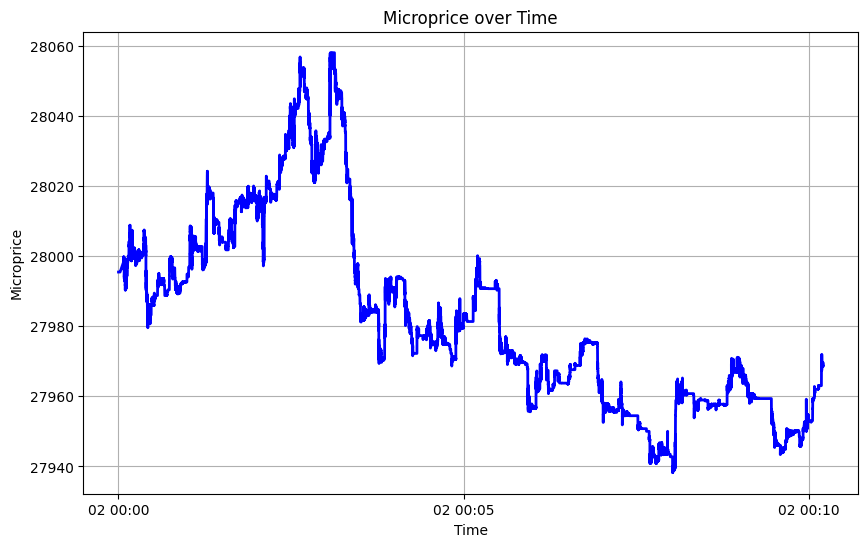

In [51]:
plt.figure(figsize=(10, 6))

df['timestamp'] = pd.to_datetime(df['timestamp'])

# Plotting the microprice with a blue line
plt.plot(df['timestamp'], df['microprice'], color='blue', linewidth=2, label='Microprice')

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Microprice')
plt.title('Microprice over Time')

# Displaying the grid
plt.grid(True)

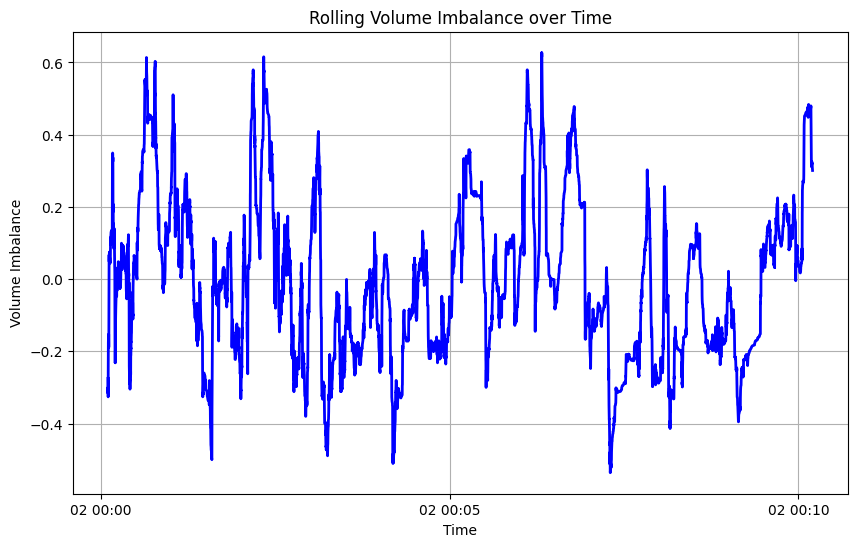

In [52]:
plt.figure(figsize=(10, 6))

# Plotting the microprice with a blue line
plt.plot(df['timestamp'], df['vol_imbalance'].rolling(1000).mean(), color='blue',
         linewidth=2, label='Rolling Volume Imbalance')

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Volume Imbalance')
plt.title('Rolling Volume Imbalance over Time')

# Displaying the grid
plt.grid(True)

In [54]:
df['daily_volatility'] = df['daily_volatility']*np.sqrt(360000.0*24)*100
df

,timestamp,bid_prices_0,ask_prices_0,bid_quantity_0,ask_quantity_0,bid_prices_1,ask_prices_1,bid_quantity_1,ask_quantity_1,bid_prices_2,...,time_bid_prices_1,time_ask_prices_1,time_bid_prices_2,time_bid_prices_3,time_ask_prices_3,time_bid_prices_4,time_ask_prices_4,vol_imbalance,microprice,daily_volatility
0,2023-10-02 00:00:00.047811072,27995.45,27995.46,2.969115,0.171891,27994.28,27996.67,0.115522,0.020000,27994.26,...,0.38,0.59,0.44,0.44,0.44,0.44,0.44,0.890551,27995.450547,NaN
1,2023-10-02 00:00:00.199801088,27995.45,27995.46,2.969115,0.171891,27994.28,27996.67,0.078016,0.020000,27994.26,...,0.23,0.43,0.29,0.29,0.29,0.29,0.29,0.890551,27995.450547,NaN
2,2023-10-02 00:00:00.242750976,27995.45,27995.46,2.969115,0.421891,27994.28,27996.67,0.078016,0.020000,27994.26,...,0.18,0.39,0.24,0.24,0.25,0.24,0.25,0.751171,27995.451244,NaN
3,2023-10-02 00:00:00.303438848,27995.45,27995.46,2.969115,0.421891,27994.28,27996.67,0.078016,0.020000,27994.26,...,0.12,0.33,0.18,0.18,0.12,0.18,0.12,0.751171,27995.451244,NaN
4,2023-10-02 00:00:00.395410176,27995.45,27995.46,2.969115,0.420490,27994.28,27996.67,0.078016,0.020000,27994.26,...,0.03,0.24,0.09,0.09,0.02,0.09,0.02,0.751894,27995.451241,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103081,2023-10-02 00:10:12.153671936,27968.27,27970.24,0.171501,0.020000,27968.26,27970.25,0.020000,0.053564,27967.98,...,0.00,85787.85,0.00,0.00,85787.85,0.00,85787.85,0.791124,27968.475743,74.788650
103082,2023-10-02 00:10:12.154450944,27968.28,27970.24,0.158101,0.020000,27968.27,27970.25,0.171501,0.053564,27968.26,...,85787.85,85787.85,85787.85,85787.85,85787.85,0.00,85787.85,0.775408,27968.500100,74.790967
103083,2023-10-02 00:10:12.158212864,27968.28,27970.24,0.158101,0.020000,27968.27,27970.25,0.171501,0.053564,27968.26,...,85787.84,85787.84,85787.84,85787.84,85787.84,85787.84,85787.84,0.775408,27968.500100,74.790958
103084,2023-10-02 00:10:12.158674944,27968.28,27970.24,0.158101,0.020000,27968.27,27970.25,0.171501,0.053564,27968.26,...,85787.84,85787.84,85787.84,85787.84,85787.84,85787.84,85787.84,0.775408,27968.500100,74.790948


In [55]:
df.dropna(inplace=True)
df.describe()

,bid_prices_0,ask_prices_0,bid_quantity_0,ask_quantity_0,bid_prices_1,ask_prices_1,bid_quantity_1,ask_quantity_1,bid_prices_2,ask_prices_2,...,time_bid_prices_1,time_ask_prices_1,time_bid_prices_2,time_bid_prices_3,time_ask_prices_3,time_bid_prices_4,time_ask_prices_4,vol_imbalance,microprice,daily_volatility
count,102087.000000,102087.000000,1.020870e+05,1.020870e+05,102087.000000,102087.000000,1.020870e+05,102087.000000,102087.000000,102087.000000,...,102087.000000,102087.000000,102087.000000,102087.000000,102087.000000,102087.000000,102087.000000,102087.000000,102087.000000,102087.000000
mean,27990.290168,27991.935258,1.731104e-01,1.679133e-01,27989.765561,27992.535251,1.937127e-01,0.155106,27989.369334,27993.047075,...,1764.227558,2155.492736,1471.139642,1268.921424,1333.969550,977.479764,1135.409376,0.007154,27991.118443,213.727257
std,28.823251,28.959333,2.866734e-01,4.303660e-01,28.754530,28.991063,3.350312e-01,0.514485,28.701522,29.012590,...,12195.788897,13441.540153,11156.570263,10373.126978,10624.537976,9118.333086,9812.590941,0.636706,28.890998,359.445916
min,27938.200000,27938.980000,3.000000e-08,1.000000e-08,27936.380000,27938.990000,3.500000e-07,0.000002,27936.270000,27939.270000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,27938.219139,8.214423
25%,27965.640000,27967.610000,4.000000e-02,4.000000e-02,27965.180000,27968.430000,4.649566e-02,0.045106,27964.730000,27969.140000,...,0.000000,0.010000,0.000000,0.000000,0.010000,0.000000,0.000000,-0.569507,27966.562814,32.991369
50%,27990.360000,27991.140000,8.000000e-02,7.271321e-02,27989.610000,27991.950000,8.927587e-02,0.072713,27989.120000,27992.340000,...,0.010000,0.180000,0.010000,0.010000,0.070000,0.010000,0.050000,0.008964,27990.763831,59.460616
75%,28013.170000,28014.820000,2.500000e-01,2.405333e-01,28012.420000,28015.030000,2.500000e-01,0.212412,28012.150000,28015.100000,...,0.210000,1.820000,0.140000,0.110000,0.730000,0.090000,0.490000,0.580512,28013.893711,188.473722
max,28057.990000,28058.000000,5.000000e+00,1.874256e+01,28057.550000,28062.620000,5.000000e+00,18.742559,28057.540000,28062.900000,...,86215.730000,86215.770000,86215.730000,86213.460000,86215.770000,86213.460000,86215.770000,1.000000,28058.000000,2006.112857


In [56]:
df.to_csv('prepared_LOB_trunc_data.csv')

In [64]:
N = 100  # Define the number of previous observations included

# Assuming 'columns' is a list of column names and 'column' is a specific column name
columns_to_drop = ['time_' + col for col in columns] + ['timestamp']
X = df.drop(columns=columns_to_drop).iloc[:len(df)//10]
Y = df[['time_' + col for col in columns]].iloc[N:len(df)//10].values

print(Y.shape)

(10108, 9)


In [65]:
tensor_slices = []

for i in range(N, len(X)):
    start_index = max(0, i - N)
    slice_df = X.iloc[start_index:i+1]

    tensor_slice = tf.convert_to_tensor(slice_df, dtype=tf.float32)
    tensor_slices.append(tensor_slice)

X = tf.stack(tensor_slices)

print(X.shape)

(10108, 101, 23)


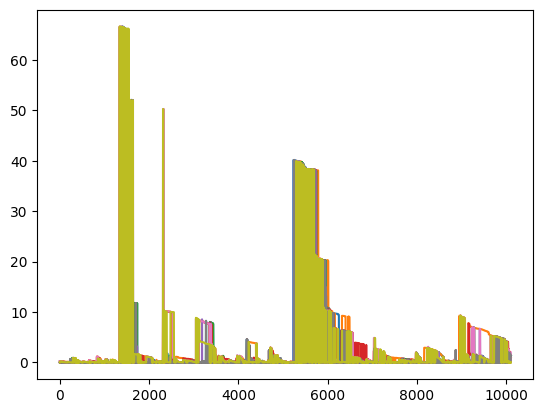

In [66]:
plt.plot(Y)

In [77]:
threshold = 5 # check if executed after 5 sec
for column in columns:
  df['time_' + column] = df['time_' + column].apply(lambda x: 1 if x < threshold else 0)

In [78]:
df

,timestamp,bid_prices_0,ask_prices_0,bid_quantity_0,ask_quantity_0,bid_prices_1,ask_prices_1,bid_quantity_1,ask_quantity_1,bid_prices_2,...,time_bid_prices_1,time_ask_prices_1,time_bid_prices_2,time_bid_prices_3,time_ask_prices_3,time_bid_prices_4,time_ask_prices_4,vol_imbalance,microprice,daily_volatility
999,2023-10-02 00:00:06.051655936,0,0,0.072713,0.188,0,0,0.150000,0.060000,0,...,0.01,0.00,0.01,0.01,0.00,0.01,0.00,-0.442198,27995.399481,494.105453
1000,2023-10-02 00:00:06.051817984,0,0,0.072713,0.188,0,0,0.150000,0.177791,0,...,0.01,1.21,0.01,0.01,1.22,0.01,1.22,-0.442198,27995.399481,494.105453
1001,2023-10-02 00:00:06.051911168,0,0,0.072713,0.188,0,0,0.150000,0.177791,0,...,0.01,1.21,0.01,0.01,1.22,0.01,1.22,-0.442198,27995.399481,494.105386
1002,2023-10-02 00:00:06.051913984,0,0,0.150000,0.188,0,0,0.250000,0.177791,0,...,0.01,1.21,0.01,0.01,1.22,0.01,1.22,-0.112426,27994.895089,494.065679
1003,2023-10-02 00:00:06.052875008,0,0,0.150000,0.188,0,0,0.250000,0.177791,0,...,0.01,1.21,0.01,0.01,1.21,0.01,1.21,-0.112426,27994.895089,494.065680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103081,2023-10-02 00:10:12.153671936,0,0,0.171501,0.020,0,0,0.020000,0.053564,0,...,0.00,85787.85,0.00,0.00,85787.85,0.00,85787.85,0.791124,27968.475743,74.788650
103082,2023-10-02 00:10:12.154450944,0,0,0.158101,0.020,0,0,0.171501,0.053564,0,...,85787.85,85787.85,85787.85,85787.85,85787.85,0.00,85787.85,0.775408,27968.500100,74.790967
103083,2023-10-02 00:10:12.158212864,0,0,0.158101,0.020,0,0,0.171501,0.053564,0,...,85787.84,85787.84,85787.84,85787.84,85787.84,85787.84,85787.84,0.775408,27968.500100,74.790958
103084,2023-10-02 00:10:12.158674944,0,0,0.158101,0.020,0,0,0.171501,0.053564,0,...,85787.84,85787.84,85787.84,85787.84,85787.84,85787.84,85787.84,0.775408,27968.500100,74.790948


In [81]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size_Q, kernel_size_K, kernel_size_V, units, dilation_rate, num_heads):
        super(Encoder, self).__init__()
        self.units = units
        self.dilation_rate = dilation_rate

        # Dilated Convolution layer
        self.dilated_conv_Q = tf.keras.layers.Conv1D(kernel_size=kernel_size_Q,
                                                  filters=filters,
                                                  dilation_rate=self.dilation_rate,
                                                  padding='causal',
                                                  activation='relu')

        self.dilated_conv_K = tf.keras.layers.Conv1D(kernel_size=kernel_size_K,
                                                  filters=filters,
                                                  dilation_rate=self.dilation_rate,
                                                  padding='causal',
                                                  activation='relu')

        self.dilated_conv_V = tf.keras.layers.Conv1D(kernel_size=kernel_size_V,
                                                  filters=filters,
                                                  dilation_rate=self.dilation_rate,
                                                  padding='causal',
                                                  activation='relu')


        # Multi-Head Attention layer with 3 heads
        self.multi_head_attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=16)

        # Flatten layer to reduce to a one-dimensional array
        self.flatten = tf.keras.layers.Flatten()

    def call(self, x):
        # Dilated Convolution
        Q = self.dilated_conv_Q(x)
        K = self.dilated_conv_K(x)
        V = self.dilated_conv_V(x)
        # Multi-Head Attention
        x = self.multi_head_attention(Q, K, V)

        # Flatten the output
        x = self.flatten(x)

        return x

class SimpleDecoder(tf.keras.layers.Layer):
    def __init__(self, num_layers=10, units_per_layer=64, activation='relu', l1_reg=0.1, dropout_rate=0.1):
        super(SimpleDecoder, self).__init__()
        self.num_layers = num_layers
        self.units_per_layer = units_per_layer
        self.activation = activation
        self.l1_reg = l1_reg
        self.dropout_rate = dropout_rate

        # Initialize dense layers with L1 regularization and Dropout layers
        self.layers = []
        for _ in range(num_layers):
            self.layers.append(layers.Dense(units=self.units_per_layer,
                                            activation=self.activation,
                                            kernel_regularizer=regularizers.l1(self.l1_reg)))
            self.layers.append(layers.Dropout(self.dropout_rate))





    def call(self, inputs, training=False):
        x = inputs
        for layer in self.layers:
            if isinstance(layer, layers.Dropout):
                x = layer(x, training=training)  # Only apply dropout during training
            else:
                x = layer(x)
        return x

def create_encoder(input_shape, d_model, num_heads, dilation_rate, kernel_size_Q, kernel_size_K, kernel_size_V):
    return Encoder(units=d_model, filters=filters, kernel_size_Q=kernel_size_Q, kernel_size_K=kernel_size_K, kernel_size_V=kernel_size_V, dilation_rate=dilation_rate, num_heads=num_heads)

# Combine the encoder and decoder to create the full model
def create_full_model(input_shape, filters, num_heads, d_model, output_shape, units, kernel_size_Q, kernel_size_K, kernel_size_V):
    encoder_inputs = layers.Input(shape=input_shape)
    encoder = create_encoder(input_shape, d_model, num_heads, filters, kernel_size_Q, kernel_size_K, kernel_size_V)
    encoder_output = encoder(encoder_inputs)

    decoder = SimpleDecoder()
    decoder_output = decoder(encoder_output)

    # Flatten the decoder output if not already flattened
    flat_output = tf.keras.layers.Flatten()(decoder_output)
    output = tf.keras.layers.Dense(output_shape, activation= 'sigmoid')(flat_output)
    full_model = tf.keras.models.Model(inputs=encoder_inputs, outputs=output)

    return full_model

In [ ]:
# Define model parameters
input_shape = (N+1, 23)
filters = 2
units = 4
kernel_size_Q, kernel_size_K, kernel_size_V = 2, 3, 4
num_heads = 3
d_model = 2
output_shape = Y.shape[1]
batch = 16

# Create the model
model = create_full_model(input_shape, filters, num_heads, d_model, output_shape, units, kernel_size_Q, kernel_size_K, kernel_size_V)
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=10**(-4)),
              loss='binary_crossentropy')


# Train the model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
model.fit(x=X, y=Y, batch_size=batch, epochs=100, callbacks=[callback])

Epoch 1/100
632/632 [==============================] - 16s 23ms/step - loss: 4072.0276
Epoch 2/100
632/632 [==============================] - 16s 26ms/step - loss: 604.4328
Epoch 3/100
632/632 [==============================] - 15s 23ms/step - loss: 538.5667
Epoch 4/100
632/632 [==============================] - 20s 32ms/step - loss: 522.3819
Epoch 5/100
632/632 [==============================] - 20s 32ms/step - loss: 516.4158
Epoch 6/100
632/632 [==============================] - 25s 40ms/step - loss: 511.1078
Epoch 7/100
632/632 [==============================] - 16s 25ms/step - loss: 504.9042
Epoch 8/100
632/632 [==============================] - 18s 28ms/step - loss: 498.5620
Epoch 9/100
632/632 [==============================] - 22s 35ms/step - loss: 491.3596
Epoch 10/100
632/632 [==============================] - 23s 36ms/step - loss: 482.8891
Epoch 11/100
632/632 [==============================] - 17s 28ms/step - loss: 473.5952
Epoch 12/100
632/632 [=============================

316/316 [==============================] - 6s 17ms/step


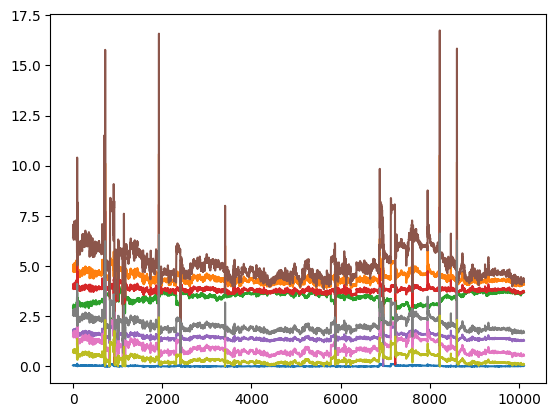

In [75]:
Y_pred = model.predict(X)

plt.plot(Y_pred)

In [ ]:
# Define model parameters
input_shape = (N+1, 23)
output_shape = Y.shape[1]

In [ ]:
# Optuna objective function
def objective(trial):
    # Suggest values for the hyperparameters
    num_heads = trial.suggest_categorical('num_heads', [2, 4, 8, 16])
    filters = trial.suggest_categorical('filters', [2, 4, 8, 16])
    units = trial.suggest_categorical('units', [1, 4, 8, 16, 32])
    kernel_size_Q = trial.suggest_categorical('kernel_size_Q', [2, 4, 8, 16])
    kernel_size_K = trial.suggest_categorical('kernel_size_K', [2, 4, 8, 16])
    kernel_size_V = trial.suggest_categorical('kernel_size_V', [2, 4, 8, 16])
    dilation_rate = trial.suggest_categorical('dilation_rate', [1, 2, 3, 4])
    d_model = trial.suggest_categorical('d_model', [1, 2, 4, 8, 32])
    batch = trial.suggest_categorical('batch', [4, 8, 16, 32])
    learning_rate = trial.suggest_categorical('learning_rate', [1e-6, 1e-5, 1e-4, 1e-3, 1e-1])  # Suggest learning rate

    # Create the model using the suggested values
    model = create_full_model(input_shape, filters, kernel_size, num_heads, d_model, output_shape, units)

    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),loss='mse')

    train_ds = tf.data.Dataset.from_tensor_slices((X, Y)).batch(batch_size = batch)

    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
    history = model.fit(train_ds, epochs=50, callbacks=[callback], verbose=1)

    val_loss = sum(history.history['loss'][-6:-1])/5
    return val_loss

# Optuna study
study = optuna.create_study(direction='minimize')  # 'minimize' if lower loss is better, 'maximize' otherwise
study.optimize(objective, n_trials=50)  # Adjust the number of trials

# Print the optimal hyperparameters
print('Best trial:')
trial = study.best_trial
print(f'  Value: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

In [ ]:
# Define model parameters
input_shape = (N+1, 23)
output_shape = Y.shape[1]
num_heads = trial.params['num_heads']
filters = trial.params['filters']
units = trial.params['units']
kernel_size = trial.params['kernel_size']
d_model = trial.params['d_model']
batch = trial.params['batch']
learning_rate = trial.params['learning_rate']
# Create the model
model = create_full_model(input_shape, filters, kernel_size, num_heads, d_model, output_shape, units)

# Create TensorFlow dataset
train_ds = tf.data.Dataset.from_tensor_slices((X, Y)).batch(batch_size=batch)

model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),
              loss='mse')

# Train the model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15)
model.fit(train_ds, epochs=100, callbacks=[callback])

In [ ]:
Y_pred = model.predict(X)

In [ ]:
plt.plot(Y_pred)
plt.plot(Y)

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

In [ ]:
shap_explanation = shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value,
    data=X,  # or a subset of X for large datasets
    feature_names=X.columns,  # replace with your actual feature names
    output_names=["Prediction"]
)

# Generate the waterfall plot for the first prediction
shap.waterfall_plot(shap_explanation[0])